In [22]:
import os
import pandas as pd
import sys
import numpy as np
import sys
sys.path.insert(0, '../..')
import itertools

from genepy.utils import helper as h
from genepy.epigenetics import chipseq as chip

import dalmatian as dm
import pyBigWig

from bokeh.plotting import *
from IPython.display import IFrame
import igv
from biomart import BiomartServer
import io

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## v11 MEF2C degraded v2

In [23]:
project="MEF2D_degraded_v4"
loc1= "210312_MP8736_fastq"

In [24]:
fastq1 = ! gsutil ls gs://transfer-amlproject/$loc1/
fastq1

['gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R1_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R2_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R1_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R2_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_A_MP8736_S7_R1_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_A_MP8736_S7_R2_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_B_MP8736_S8_R1_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_B_MP8736_S8_R2_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MEF2C_A_MP8736_S5_R1_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MEF2C_A_MP8736_S5_R2_001.fastq.gz',
 'gs://transfer-amlproject/210312_MP87

In [6]:
mkdir ../data/$project/ && mkdir ../data/$project/qc/

In [7]:
!gsutil -m cp gs://transfer-amlproject/$loc1/multiqc_report.html ../data/$project/qc/
!gsutil -m cp -r gs://transfer-amlproject/$loc1/Reports/ ../data/$project/qc/
!gsutil -m cp -r gs://transfer-amlproject/$loc1/multiqc_data/ ../data/$project/qc/

Copying gs://transfer-amlproject/210312_MP8736_fastq/multiqc_report.html...
/ [1/1 files][  1.5 MiB/  1.5 MiB] 100% Done                                    
Operation completed over 1 objects/1.5 MiB.                                      
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_A_MP8736_S138_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_A_MP8736_S138_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_A_MP8736_S138_R2_001_fastqc.html...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_A_MP8736_S138_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_B_MP8736_S139_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_FLAG_B_MP8736_S139_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210312_MP8736_fastq/Reports/2021031

In [25]:
! gsutil -m cp gs://transfer-amlproject/$loc1/*  gs://transfer-amlproject/$project/

Omitting prefix "gs://transfer-amlproject/210312_MP8736_fastq/Reports/". (Did you mean to do cp -r?)
Omitting prefix "gs://transfer-amlproject/210312_MP8736_fastq/multiqc_data/". (Did you mean to do cp -r?)
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_A_MP8736_S7_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_MED1_B_MP87

### analysis

In [32]:
rename = {
"20210312_DMSO_FLAG_A_MP8736_S1": "mp951-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r7", 
"20210312_DMSO_FLAG_B_MP8736_S2": "mp952-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r8", 
"20210312_DMSO_MED1_A_MP8736_S7": "mp953-MV411_MEF2D_NT_SC_63_DMSO-MED1-r5", 
"20210312_DMSO_MED1_B_MP8736_S8": "mp954-MV411_MEF2D_NT_SC_63_DMSO-MED1-r6", 
"20210312_DMSO_MEF2C_A_MP8736_S5": "mp955-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r5", 
"20210312_DMSO_MEF2C_B_MP8736_S6": "mp956-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r6", 
"20210312_DMSO_MYC_A_MP8736_S3": "mp957-MV411_MEF2D_NT_SC_63_DMSO-MYC-r5", 
"20210312_DMSO_MYC_B_MP8736_S4": "mp958-MV411_MEF2D_NT_SC_63_DMSO-MYC-r6", 
"20210312_VHL_FLAG_A_MP8736_S9": "mp959-MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D-r7", 
"20210312_VHL_FLAG_B_MP8736_S10": "mp960-MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D-r8", 
"20210312_VHL_MED1_A_MP8736_S15": "mp961-MV411_MEF2D_NT_SC_63_VHL_2h-MED1-r5", 
"20210312_VHL_MED1_B_MP8736_S16": "mp962-MV411_MEF2D_NT_SC_63_VHL_2h-MED1-r6", 
"20210312_VHL_MEF2C_A_MP8736_S13": "mp963-MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C-r5", 
"20210312_VHL_MEF2C_B_MP8736_S14": "mp964-MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C-r6", 
"20210312_VHL_MYC_A_MP8736_S11": "mp965-MV411_MEF2D_NT_SC_63_VHL_2h-MYC-r5", 
"20210312_VHL_MYC_B_MP8736_S12": "mp966-MV411_MEF2D_NT_SC_63_VHL_2h-MYC-r6"}

In [33]:
for val in fastq1:
    rep = val
    for k,v in rename.items():
        rep = rep.replace(k,v)
    rep = rep.replace('transfer-amlproject/'+loc1+'/',"amlproject/Chip/"+project+'/fastqs/')
    !gsutil cp $val $rep

Copying gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/20210312_DMSO_FLAG_A_MP8736_S1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
/ [1 files][  3.7 GiB/  3.7 GiB]                                                
Operation completed over 1 objects/3.7 GiB.                                      
Copying gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/20210312_DMSO_FLAG_A_MP8736_S1_R2_001.fastq.gz [Content-Type=application/octet-stream]...
/ [1 files][  3.7 GiB/  3.7 GiB]                                                
Operation completed over 1 objects/3.7 GiB.                                      
Copying gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/20210312_DMSO_FLAG_B_MP8736_S2_R1_001.fastq.gz [Content-Type=application/octet-stream]...
/ [1 files][  2.7 GiB/  2.7 GiB]                                                
Operation completed over 1 objects/2.7 GiB.                                      
Copying gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/20210312_DMSO_FLAG_B_MP87

In [28]:
! gsutil rm gs://amlproject/Chip/$project/fastqs/multiqc_report.html
! gsutil rm -r gs://transfer-amlproject/$loc1/

Removing gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/multiqc_report.html...
/ [1 objects]                                                                   
Operation completed over 1 objects.                                              
Removing gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R1_001.fastq.gz#1616682472665810...
Removing gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_A_MP8736_S1_R2_001.fastq.gz#1616682485866906...
Removing gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R1_001.fastq.gz#1616682297298076...
Removing gs://transfer-amlproject/210312_MP8736_fastq/20210312_DMSO_FLAG_B_MP8736_S2_R2_001.fastq.gz#1616682358867355...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for furth

Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_MYC_B_MP8736_S4_R1_001_fastqc.zip#1616677047074191...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_MYC_B_MP8736_S4_R2_001_fastqc.html#1616676390232582...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_DMSO_MYC_B_MP8736_S4_R2_001_fastqc.zip#1616678067005806...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_VHL_FLAG_A_MP8736_S9_R1_001_fastqc.html#1616678066971825...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_VHL_FLAG_A_MP8736_S9_R1_001_fastqc.zip#1616677045948551...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_VHL_FLAG_A_MP8736_S9_R2_001_fastqc.html#1616677377152756...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_VHL_FLAG_A_MP8736_S9_R2_001_fastqc.zip#1616677377663635...
Removing gs://transfer-amlproject/210312_MP8736_fastq/Reports/20210312_VHL_FLAG_B_MP873

In [12]:
fastq = ! gsutil ls gs://amlproject/Chip/$project/fastqs/
fastq

['gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp951-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r7_R1_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp951-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r7_R2_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp952-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r8_R1_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp952-MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D-r8_R2_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp953-MV411_MEF2D_NT_SC_63_DMSO-MED1-r5_R1_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp953-MV411_MEF2D_NT_SC_63_DMSO-MED1-r5_R2_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp954-MV411_MEF2D_NT_SC_63_DMSO-MED1-r6_R1_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp954-MV411_MEF2D_NT_SC_63_DMSO-MED1-r6_R2_001.fastq.gz',
 'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp955-MV411_MEF2D_NT_SC_63_DMSO-MEF2C-r5_R1_001.fastq.gz',
 'gs://amlproject/Chi

In [13]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
url="https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U"
gsheet = sheets.get(url).sheets[2].to_frame()

In [21]:
df.iloc[7].values

array(['gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp958-MV411_MEF2D_NT_SC_63_DMSO-MYC-r6_R1_001.fastq.gz',
       'gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/mp958-MV411_MEF2D_NT_SC_63_DMSO-MYC-r6_R2_001.fastq.gz',
       'MYC', 'MV411_MEF2D_NT_SC_63_DMSO-MYC', 2, 'INPUT'], dtype=object)

In [18]:
df = {
"fastq_1": [],
"fastq_2": [],
"antibody": [],
"group": [],
"replicate": [],
"control": []
}
for val in h.grouped(fastq,2):
    row = gsheet[gsheet.id==val[0].split('/')[-1].split('-')[0]]
    df['group'].append("MV4"+row['name'].values[0].split('-r')[0].split('-MV4')[1])
    df['replicate'].append(df['group'].count(df['group'][-1]))
    df['fastq_1'].append(val[0])
    df['fastq_2'].append(val[1])
    df['antibody'].append(row['protein'].values[0])
    df['control'].append("INPUT")
df['group'].append('INPUT')
df['replicate'].append(1)
df['fastq_1'].append('gs://amlproject/Chip/fastqs/paired_end/mp845-MV411-INPUT-r2_R1.fastq.gz')
df['fastq_2'].append('gs://amlproject/Chip/fastqs/paired_end/mp845-MV411-INPUT-r2_R2.fastq.gz')
df['antibody'].append("")
df['control'].append("")
df = pd.DataFrame(df)
df[df.columns[[3,4,0,1,2,5]]].to_csv('../nextflow/'+project+'_design.csv',index=False)
df

,fastq_1,fastq_2,antibody,group,replicate,control
0,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D,1,INPUT
1,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D,2,INPUT
2,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MED1,MV411_MEF2D_NT_SC_63_DMSO-MED1,1,INPUT
3,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MED1,MV411_MEF2D_NT_SC_63_DMSO-MED1,2,INPUT
4,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MEF2C,MV411_MEF2D_NT_SC_63_DMSO-MEF2C,1,INPUT
5,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MEF2C,MV411_MEF2D_NT_SC_63_DMSO-MEF2C,2,INPUT
6,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MYC,MV411_MEF2D_NT_SC_63_DMSO-MYC,1,INPUT
7,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,MYC,MV411_MEF2D_NT_SC_63_DMSO-MYC,2,INPUT
8,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D,1,INPUT
9,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,gs://amlproject/Chip/MEF2D_degraded_v4/fastqs/...,FLAG_MEF2D,MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D,2,INPUT


### about

0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`

In [ ]:
! cd ../../ && ./nextflow log ## to get access to the previous runs

In [ ]:
#process chips 
! cd ../../ && ./nextflow run jkobject/chipseq --paired_end --seq_center 'DFCI' --email 'jkobject@gmail.com' --input AMLproject/nextflow/MEF2D_degraded_v4_design.csv --genome GRCh38 --max_cpus 16 -profile jkcloud -w gs://workamlproject/MEF2Dv4res --spiking --skip_diff_analysis --outdir gs://workamlproject/MEF2Dv4 --tracedir AMLproject/nextflow/MEF2Ddegradedv4/

In [37]:
! gsutil -m cp -r gs://workamlproject/MEF2Dv4/* gs://amlproject/Chip/$project/

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.sorted.bam [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.sorted.bam.bai [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.mLb.clN.sorted.bam [Conten

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/bigwig/scale/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2.scale_factor.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproj

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R1.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R1.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R1.plotFingerprint.raw.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2.plotFingerprint.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2.plotFingerprint.qcmetrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotFingerprint/M

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.plotProfile.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.plotHeatmap.pdf [Co

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R1.plotProfile.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.computeMatrix.mat.gz [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.computeMatrix.vals.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.plotHeatmap.mat.tab [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.plotHeatmap.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/deepTools/plotProfile/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.plotPro

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_peaks.xls [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_peaks.broadPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_peaks.gappedPeak [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_peaks.xls [Content-Type=application/octet-stream]...


Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.bed [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.boolean.annotatePeaks.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.boolean.intersect.plot.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.boolean.intersect.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.boolean.txt [Content-Type=application/octet-st

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/qc/macs_annotatePeaks.plots.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/qc/macs_annotatePeaks.summary.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/qc/macs_annotatePeaks.summary_mqc.tsv [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/qc/macs_peak.plots.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/macs/broadPeak/qc/macs_peak.summary.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/phantompeakqualtools/INPUT_R1.spp.out [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/phantompeakqualtools/INPUT_R1.spp.pdf [Content-Type=application/octet-stream]...
Copying gs://worka

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMetrics.alignment_summary_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMetrics.insert_size_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=appl

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.insert_size_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.mkD.MarkDuplicates.metrics.txt [Cont

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2.mLb.clN.CollectMultipleMetrics.insert_size_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2.mLb.clN.CollectMultipleMetrics.quality_by_cycle_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2.mLb.clN.CollectMultipleMetrics.quality_distribution_metrics [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2.mLb.mkD.MarkDuplicates.metrics.txt [Content-Type=application/octet-stream].

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/pdf/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.insert_size_histogram.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/pdf/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/pdf/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.CollectMultipleMetrics.quality_distribution.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/pdf/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMetrics.base_distribution_by_cycle.pdf [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/picard_metrics/pdf/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.mLb.clN.CollectMultipleMet

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.command.log [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.ccurve.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/preseq/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.mkD.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.mLb.clN.sorted.bam.stats

Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.clN.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.clN.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.clN.sorted.bam.stats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.mkD.sorted.bam.flagstat [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.mkD.sorted.bam.idxstats [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/bwa/mergedLibrary/samtools_stats/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2.mLb.mkD.sort

Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_T1_scaling.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/droso_aligned/scale/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_T1_scaling.txt

Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_T1_2_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2_T1_2_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2_T1_1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_T1_1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_T1_2_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_T1_1_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/fastqc/zips/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_T1_2_fastqc.zip [Content-Type=application/octet-stream]...
Copying gs://w

Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R1_T1_1_val_1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R1_T1_2_val_2_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2_T1_1_val_1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MEF2C_R2_T1_2_val_2_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R1_T1_1_val_1_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R1_T1_2_val_2_fastqc.html [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/fastqc/M

Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_T1_2.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_T1_1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2_T1_2.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_T1_1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_T1_2.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream]...
Copying gs://workamlproject/MEF2Cv4/trim_galore/logs/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_T1_1.fastq.gz_trimming_report.txt [Content-Type=application/octet-stream

In [38]:
! gsutil cat gs://amlproject/Chip/$project/droso_aligned/counts/*
! gsutil ls gs://amlproject/Chip/$project/droso_aligned/counts/

5005582
4697572
2270286
5969076
2452426
6789258
1420870
3083526
721324
2698156
9569526
2891814
2536276
2710666
2404420
4073360
3639444
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/INPUT_R1_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2_T1_counts.txt
gs://amlproject/Chip/MEF2D_degraded_v4/droso_aligned/counts/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_T1_counts.txt
gs://amlproje

#### now use the total counts in gs://amlproject/Chip/MEF2D_degraded_v4/multiqc/broadPeak/multiqc_report.html
##### https://console.cloud.google.com/storage/browser/amlproject/Chip/MEF2D_degraded_v4/multiqc/broadPeak/multiqc_report.html

In [41]:
h.createFoldersFor('../../data/'+project+'/bwa/mergedLibrary/')
!gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/*.ba* ../../data/$project/bwa/mergedLibrary/
! gsutil -m cp -r gs://amlproject/Chip/$project/bwa/mergedLibrary/bigwig/ ../../data/$project/bwa/mergedLibrary/
! gsutil  -m cp -r gs://amlproject/Chip/$project/bwa/mergedLibrary/macs/ ../../data/$project/bwa/mergedLibrary/

Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.mLb.clN.sorted.bam...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.mLb.clN.sorted.bam.bai...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/b

| [34/34 files][  6.0 GiB/  6.0 GiB] 100% Done 204.8 MiB/s ETA 00:00:00         
Operation completed over 34 objects/6.0 GiB.                                     
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.annotatePeaks.txt...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.gappedPeak...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.xls...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_peaks.annotatePeaks.txt...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_peaks.broad

Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MYC/MYC.consensus_peaks.saf...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.FRiP_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_peaks.FRiP_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_peaks.count_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.count_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1_peaks.FRiP_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R2_peaks.broadPeak...
Copying gs://amlproject/

Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_peaks.FRiP_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MYC/MYC.consensus_peaks.featureCounts.txt...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/qc/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1_peaks.count_mqc.tsv...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MYC/MYC.consensus_peaks.featureCounts.txt.summary...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MYC/MYC.consensus_peaks.boolean.intersect.plot.pdf...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MED1/MED1.consensus_peaks.bed...
Copying gs://amlproject/Chip/MEF2D_degraded_v4/bwa/mergedLibrary/macs/broadPeak/consensus/MEF2C/MEF2C.consensus_peaks.boolean.txt...
Copying gs://amlproject/Chip/MEF2D_degraded_v

computing scales from the excel sheet

In [39]:
scales = [
1.00,
1.00,
1.00,
1.00,
0.74,
1.00,
1.00,
1.00,
    
0.58,
0.17,
0.95,
0.81,
1.00,
0.19,
0.82,
0.17,
         ]

In [42]:
bams = ! ls ../../data/$project/bwa/mergedLibrary/*.bam
bams

['../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-

### on scalled data

In [43]:
! mkdir ../../data/$project/diffPeaks/ && ! mkdir ../../data/$project/diffData/

In [44]:
wigs = ! ls ../../data/$project/bwa/mergedLibrary/bigwig/*.bigWig
wigs

['../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/INPUT_R1.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.bigWig',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.bigWig',
 '../../data/ME

#### diffPeak on scaled data (full reprocessing)


In [71]:
int(len(bams)/2)-1

7

In [72]:
bams

['../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.mLb.clN.sorted.bam',
 '../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-

In [80]:
sizes = [185, 195, 193, 178, 219, 192]
scaling = [(55643168, 18794377),(41321525, 30677381),(50794602, 23259917),(40782010, 177746852),(52890681, 26153680),(66632615, 154320647)]
directory="../../data/"+project+"/diffData/"
for i in range(int(len(bams)/2)-1):
    if i != 3:
        continue
    bam1 = bams[1+i]
    bam2 = bams[9+i]
    name1 = bam1.split('/')[-1].split('.')[0]
    name2 = bam2.split('/')[-1].split('.')[0]
    print(await chip.diffPeak(directory+name1+"_treat_pileup.bdg", directory+name2+"_treat_pileup.bdg",
    directory+name1+"_control_lambda.bdg", directory+name2+"_control_lambda.bdg",
    "../../data/"+project+"/diffPeaks/", scaling[i][0], scaling[i][1], sizes[i]))

doing differential peak binding
CompletedProcess(args='macs3 bdgdiff --t1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2_treat_pileup.bdg --c1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2_control_lambda.bdg --t2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2_treat_pileup.bdg --c2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2_control_lambda.bdg --d1 40782010 --d2 177746852 -g 60 -l 178 --o-prefix MV411_MEF2D_NT_SC_63_DMSO-MED1_R2_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R2_treat_pileup --outdir ../../data/MEF2D_degraded_v4/diffPeaks/', returncode=0, stdout=b'', stderr=b'INFO  @ Fri, 02 Apr 2021 21:13:05: Read and build treatment 1 bedGraph... \nINFO  @ Fri, 02 Apr 2021 21:14:24: Read and build control 1 bedGraph... \nINFO  @ Fri, 02 Apr 2021 21:19:43: Read and build treatment 2 bedGraph... \nINFO  @ Fri, 02 Apr 2021 21:20:47: Read and build control 2 bedGraph... \nINFO  @ F

In [81]:
for i in range(int(len(bams)/2)):
    if i > 1:
        continue
    bam1 = bams[1+i]
    bam2 = bams[9+i]
    print(await chip.fullDiffPeak(bam1,bam2, control1=bams[0], scaling=[scales[i], scales[i+8]], directory = "../../data/"+project+"/diffData/", res_directory = "../../data/"+project+"/diffPeaks/",pairedend=True))

doing diff from ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam and ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.sorted.bam
computing the fragment avg size
185
computing the scaling values
b'INFO  @ Mon, 05 Apr 2021 18:35:13: \n# Command line: callpeak -B -t ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam -c ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam --nomodel --extsize 185 -n MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1 --outdir ../../data/MEF2D_degraded_v4/diffData/ -f BAMPE\n# ARGUMENTS LIST:\n# name = MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1\n# format = BAMPE\n# ChIP-seq file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.mLb.clN.sorted.bam\']\n# control file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam\']\n# eff

b'INFO  @ Mon, 05 Apr 2021 19:10:03: \n# Command line: callpeak -B -t ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.sorted.bam -c ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam --nomodel --extsize 185 -n MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1 --outdir ../../data/MEF2D_degraded_v4/diffData/ -f BAMPE\n# ARGUMENTS LIST:\n# name = MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1\n# format = BAMPE\n# ChIP-seq file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.mLb.clN.sorted.bam\']\n# control file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam\']\n# effective genome size = 2.70e+09\n# band width = 300\n# model fold = [5, 50]\n# qvalue cutoff = 5.00e-02\n# The maximum gap between significant sites is assigned as the read length/tag size.\n# The minimum length of peaks is assigned as the predicted fragment length "d".\n# Larger dataset will

CompletedProcess(args='macs3 bdgdiff --t1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup.bdg --c1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_control_lambda.bdg --t2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_treat_pileup.bdg --c2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_control_lambda.bdg --d1 55643168 --d2 30783894 -g 60 -l 185 --o-prefix MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_treat_pileup --outdir ../../data/MEF2D_degraded_v4/diffPeaks/', returncode=0, stdout=b'', stderr=b'INFO  @ Mon, 05 Apr 2021 19:36:55: Read and build treatment 1 bedGraph... \nINFO  @ Mon, 05 Apr 2021 19:38:47: Read and build control 1 bedGraph... \nINFO  @ Mon, 05 Apr 2021 19:42:44: Read and build treatment 2 bedGraph... \nINFO  @ Mon, 05 Apr 2021 19:43:21: Read and build control 2 bedGraph... \nINFO  

b'INFO  @ Mon, 05 Apr 2021 20:32:12: \n# Command line: callpeak -B -t ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.mLb.clN.sorted.bam -c ../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam --nomodel --extsize 195 -n MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2 --outdir ../../data/MEF2D_degraded_v4/diffData/ -f BAMPE\n# ARGUMENTS LIST:\n# name = MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2\n# format = BAMPE\n# ChIP-seq file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.mLb.clN.sorted.bam\']\n# control file = [\'../../data/MEF2D_degraded_v4/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam\']\n# effective genome size = 2.70e+09\n# band width = 300\n# model fold = [5, 50]\n# qvalue cutoff = 5.00e-02\n# The maximum gap between significant sites is assigned as the read length/tag size.\n# The minimum length of peaks is assigned as the predicted fragment length "d".\n# Larger dataset will

CompletedProcess(args='macs3 bdgdiff --t1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_treat_pileup.bdg --c1 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_control_lambda.bdg --t2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_treat_pileup.bdg --c2 ../../data/MEF2D_degraded_v4/diffData/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_control_lambda.bdg --d1 41321525 --d2 146168700 -g 60 -l 195 --o-prefix MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_treat_pileup --outdir ../../data/MEF2D_degraded_v4/diffPeaks/', returncode=0, stdout=b'', stderr=b'INFO  @ Mon, 05 Apr 2021 21:01:15: Read and build treatment 1 bedGraph... \nINFO  @ Mon, 05 Apr 2021 21:02:37: Read and build control 1 bedGraph... \nINFO  @ Mon, 05 Apr 2021 21:06:25: Read and build treatment 2 bedGraph... \nINFO  @ Mon, 05 Apr 2021 21:07:14: Read and build control 2 bedGraph... \nINFO 

In [51]:
initscales = ! cat ../../data/$project/bwa/mergedLibrary/bigwig/scale/*.txt
initscales

['0.00744797',
 '0.00894822',
 '0.0120499',
 '0.00980334',
 '0.0122104',
 '0.0127199',
 '0.0058746',
 '0.0179515',
 '0.0166071',
 '0.027696',
 '0.019918',
 '0.0212631',
 '0.0146742',
 '0.023092',
 '0.0188428',
 '0.0167106',
 '0.0200077']

In [52]:
rescales = [val*float(initscales[1+i]) for i, val in enumerate(scales)]
rescales

[0.00894822,
 0.0120499,
 0.00980334,
 0.0122104,
 0.009412726,
 0.0058746,
 0.0179515,
 0.0166071,
 0.016063679999999997,
 0.0033860600000000006,
 0.020199945,
 0.011886102,
 0.023092,
 0.003580132,
 0.013702691999999999,
 0.0034013090000000004]

In [53]:
chip.bigWigFrom(bams[1:], 
                genome='GRCh38',scaling=rescales,
               numthreads=8)

In [54]:
!mkdir ../../data/$project/recalib_bigwig/

In [55]:
!mv bigwig/* ../../data/$project/recalib_bigwig/

In [56]:
! gsutil -m cp -r ../../data/$project/recalib_bigwig gs://amlproject/Chip/$project/

Copying file://../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-MYC_R1.bw [Content-Type=application/octet-stream]...
Copying file://../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.bw [Content-Type=application/octet-stream]...
Copying file://../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.bw [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, comp

In [83]:
os.popen('for i in $(ls ../../data/'+project+'/diffPeaks/*.bed); \
            do echo $(wc -l $i); \
            done').read().split('\n')

['417 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_treat_pileup_c3.0_common.bed',
 '243 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_treat_pileup_c3.0_cond1.bed',
 '14287 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1_treat_pileup_c3.0_cond2.bed',
 '1 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_treat_pileup_c3.0_common.bed',
 '1272 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2_treat_pileup_c3.0_cond1.bed',
 '2844 ../../data/MEF2D_degraded_v4/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL_2h-FL

In [84]:
bw = ! ls ../../data/$project/recalib_bigwig/*
bw

['../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R2.bw',
 '../../data/MEF2D_degraded_v4/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-MED1_R1.bw',
 '../../data/MEF2D_degraded_v4/reca

In [38]:
h.createFoldersFor("../results/"+project+"/plots/heatmaps/")
h.createFoldersFor("../../data/"+project+"/bwa/mergedLibrary/macs/broadPeak/")

In [39]:
! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/macs/broadPeak/*.broadPeak ../../data/$project/bwa/mergedLibrary/macs/broadPeak/

Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C_MEF2D-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R1_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C_MEF2D-H3K27AC_R2_peaks.broadPeak...
Copying gs://amlproject/Chip/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/m

In [121]:
peaks = ! ls ../../data/$project/bwa/mergedLibrary/macs/broadPeak/*.broadPeak
peaks

['../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C-H3K27AC_R1_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C-H3K27AC_R2_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C_MEF2D-H3K27AC_R1_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2C_MEF2D-H3K27AC_R2_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R1_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_MEF2D-H3K27AC_R2_peaks.broadPeak']

In [67]:
cond1peak = ! ls ../../data/$project/diffPeaks/*cond1.bed
cond2peak = ! ls ../../data/$project/diffPeaks/*cond2.bed
commonpeak = ! ls ../../data/$project/diffPeaks/*common.bed
cond1peak

["ls: cannot access '../../data/MEF2D_degraded_v4/diffPeaks/*cond1.bed': No such file or directory"]

In [46]:
mv ../../data/chipseq_MEF2D_degraded ../../data/$project

In [ ]:
for i in range(int(len(bw)/2)):
    if i <0:
        continue
    name1 = bw[i]
    name2 = bw[i+len(names)]
    peak = [cond1peak[i], commonpeak[i], cond2peak[i]]
   # for val in peak:
      #  chip.dropWeirdChromosomes(val)
    name = names[i]
    print(name1,name2)
    chip.getPeaksAt(peak, [name1, name2], bigwignames=['DMSO', 'VHL'], peaknames=['DMSO_peaks', 'common', 'VHL_peaks'], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/diffPeaks/'+name+'_mat.pdf', withDeeptools=True, torecompute=False)

In [120]:
names = ["AAVS1", "AAVS1_V2", "MEF2C", "MEF2C_V2", "MEF2C_MEF2D", "MEF2C_MEF2D_V2", "MEF2D", "MEF2D_V2"]

#### merging peaks VHL/DMSO

In [139]:
mpeaks = []
for i, val in enumerate(names[2:]):
    if i>2:
        continue
    print(val)
    dmso = peaks[i%2]
    vhl = peaks[i+2]
    chip.simpleMergePeaks(pd.concat([chip.loadPeaks(dmso), chip.loadPeaks(vhl)])).to_csv('../../data/' + project + '/' + val + '_genomewide_merged.bed', sep='\t', header=False, index=False)
    mpeaks.append('../../data/'+project+'/'+val+'_genomewide_merged.bed')

MEF2C


KeyboardInterrupt: 

#### GENOME WIDE comparison

In [122]:
dmsoname=""
condname="_ko"

In [140]:
mpeaks = ! ls ../../data/$project/*_genomewide_merged.bed

In [141]:
mpeaks = peaks[:2]+mpeaks
mpeaks

['../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R1_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/bwa/mergedLibrary/macs/broadPeak/MV411_RNP_AAVS1-H3K27AC_R2_peaks.broadPeak',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2C_genomewide_merged.bed',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2C_MEF2D_genomewide_merged.bed',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2C_MEF2D_V2_genomewide_merged.bed',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2C_V2_genomewide_merged.bed',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2D_genomewide_merged.bed',
 '../../data/MEF2CMEF2D_knockout_v1/MEF2D_V2_genomewide_merged.bed']

In [151]:
for i, val in enumerate(bw):
    if i < 5:
        continue
    name = names[i]+condname if i>2 else names[i]+dmsoname
    print(name)
    chip.getPeaksAt(mpeaks[i], bigwigs = val, bigwignames= name, peaknames=['Macs2_Peaks'], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/'+name+'_mat.pdf', withDeeptools=True, torecompute=True, legendLoc="lower-left", vmax=1)

MEF2C_MEF2D_V2_ko
CompletedProcess(args='computeMatrix reference-point -S ../../data/MEF2CMEF2D_knockout_v1/recalib_bigwig/MV411_RNP_MEF2C_MEF2D-H3K27AC_R2.bw  --referencePoint center --regionsFileName ../../data/MEF2CMEF2D_knockout_v1/MEF2C_V2_genomewide_merged.bed  --missingDataAsZero --outFileName ../../data/MEF2CMEF2D_knockout_v1/MEF2C_MEF2D_V2_ko_mat.gz --upstream 3000 --downstream 3000 --numberOfProcessors 8 && plotHeatmap --matrixFile ../../data/MEF2CMEF2D_knockout_v1/MEF2C_MEF2D_V2_ko_mat.gz --outFileName ../../data/MEF2CMEF2D_knockout_v1/MEF2C_MEF2D_V2_ko_mat.pdf --refPointLabel center -max 1 --legendLocation lower-left --regionsLabel Macs2_Peaks --plotTitle MEF2C_MEF2D_V2_ko', returncode=0, stdout=b'', stderr=b'')
MEF2D_ko
CompletedProcess(args='computeMatrix reference-point -S ../../data/MEF2CMEF2D_knockout_v1/recalib_bigwig/MV411_RNP_MEF2D-H3K27AC_R1.bw  --referencePoint center --regionsFileName ../../data/MEF2CMEF2D_knockout_v1/MEF2D_genomewide_merged.bed  --missingDataAsZ

#### making overlapping profiles

In [ ]:
for i, val in enumerate(names):
    if i <0:
        continue
    val1 = '../../data/'+project+'/' + val + dmsoname+'_mat.gz'
    val2 = '../../data/'+project+'/' + val + condname+'_mat.gz'
    
    print(val)
    chip.makeProfiles(matx=[val1,val2], matnames=['DMSO','VHL'], title=val, refpoint="center", name='../../data/'+project+'/'+val+'_combined_mat.pdf', legendLoc="lower-left")

In [ ]:
! mkdir ../results/$project/plots/scaled/diffPeaks/
! cp ../../data/$project/diffPeaks/*.pdf ../results/$project/plots/scaled/diffPeaks/

#### making average

In [94]:
from genepy.epigenetics import plot as chiplot

In [157]:
names = ["AAVS1", "MEF2C", "MEF2C_MEF2D", "MEF2D"]

In [155]:
! mv ../../data/$project/AAVS1_V2_mat.pdf ../../data/$project/AAVS1_V2_ko_mat.pdf
! mv ../../data/$project/AAVS1_V2_mat.gz ../../data/$project/AAVS1_V2_ko_mat.gz
! mv ../../data/$project/AAVS1_mat.pdf ../../data/$project/AAVS1_ko_mat.pdf
! mv ../../data/$project/AAVS1_mat.gz ../../data/$project/AAVS1_ko_mat.gz
! mv ../../data/$project/MEF2C_mat.gz ../../data/$project/MEF2C_ko_mat.gz
! mv ../../data/$project/MEF2C_mat.pdf ../../data/$project/MEF2C_ko_mat.pdf

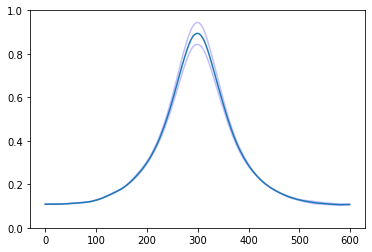

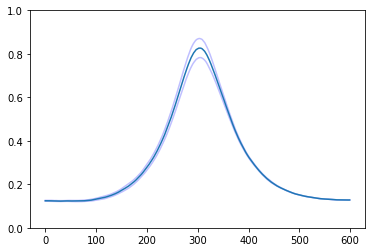

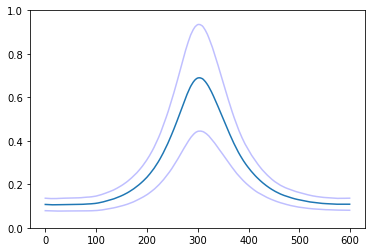

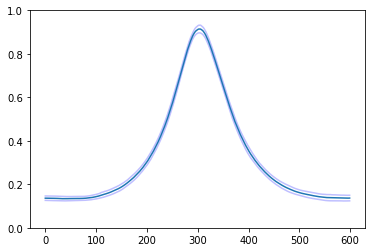

In [158]:
for i, val in enumerate(names):
    if i <0:
        continue
    val1 = '../../data/'+project+'/' + val +'_ko_mat.gz'
    val2 = '../../data/'+project+'/' + val +'_V2_ko_mat.gz'
    _ = chiplot.plotAverageOfSamples([val1, val2], folder="../../data/"+project+"/"+val, showAll=True, maxv = 1, minv=0)

In [159]:
h.createFoldersFor('../results/'+project+'/plots/scaled/heatmaps/')
! cp ../../data/$project/*_averageofsamples.pdf ../results/$project/plots/scaled/

#### looking under degraded for the presence of partner after degradation

do we see TF A appearing under TF B peaks, after TF B was degraded

In [64]:
MEF2D = chip.loadPeaks("../../data/MEF2D_degraded_v1/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak", skiprows=1)
MEF2D['MEF2C_DMSO'] = chip.putInBed(MEF2D, chip.loadPeaks("../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond1.bed", skiprows=1), window=150)
MEF2D['MEF2C_VHL'] = chip.putInBed(MEF2D, chip.loadPeaks("../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond2.bed", skiprows=1), window=150)
MEF2D['MEF2C_common'] = chip.putInBed(MEF2D, chip.loadPeaks("../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_common.bed", skiprows=1), window=150)

285 were merged into conscensus
3254 were merged into conscensus
636 were merged into conscensus


In [65]:
! wc -l ../../data/MEF2D_degraded_v1/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak
! wc -l ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond1.bed
! wc -l ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond2.bed
! wc -l ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_common.bed

17422 ../../data/MEF2D_degraded_v1/bwa/mergedLibrary/macs/broadPeak/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_peaks.broadPeak
990 ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond1.bed
7437 ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond2.bed
681 ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_common.bed


In [89]:
MEF2D['MEF2Cbis'] = chip.putInBed(MEF2D, chip.loadPeaks('../../data/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MEF2C_R1_peaks.broadPeak'), window=150)

6401 were merged into conscensus


In [90]:
! wc -l ../../data/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MEF2C_R1_peaks.broadPeak

21136 ../../data/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MEF2C_R1_peaks.broadPeak


In [96]:
MEF2D.loc[MEF2D[(MEF2D["MEF2C_VHL"]!=0) & (MEF2D["MEF2Cbis"]!=0)].index,"MEF2C_common"]=1

In [98]:
len(MEF2D[(MEF2D["MEF2C_VHL"]==0) & (MEF2D["MEF2Cbis"]!=0)]), len(MEF2D[(MEF2D["MEF2C_common"]!=0)])

(3538, 3163)

In [99]:
len(MEF2D[(MEF2D["MEF2C_VHL"]!=0) & (MEF2D["MEF2Cbis"]==0)])

429

In [97]:
chip.putInBed(chip.loadPeaks('../../data/chipseq_IRF8_degraded/bwa/mergedLibrary/macs/broadPeak/MV411_IRF8_NT_DMSO-MEF2C_R1_peaks.broadPeak'), chip.loadPeaks("../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1_treat_pileup_c3.0_cond2.bed", skiprows=1), window=150)

6490 were merged into conscensus


array([0., 0., 0., ..., 0., 0., 0.])

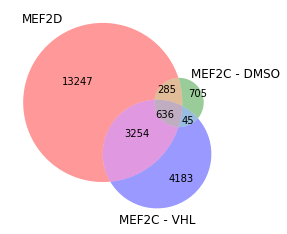

In [108]:
from matplotlib_venn import venn3
 
# Make the diagram
# A, B, AB, C, CA, CB, CBA
venn3(subsets = (17422-(3254+636+285), 990-285, 285, 7437-3254, 3254, 681-636, 636), set_labels = ('MEF2D', 'MEF2C - DMSO', 'MEF2C - VHL'))


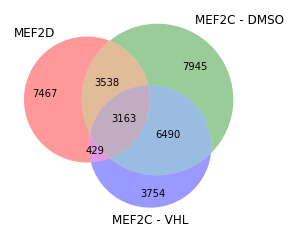

In [109]:
 # Make the diagram
# A, B, AB, C, CA, CB, CBA
venn3(subsets = (17422-(3254+3163+3538), 21136-(3538+3163+6490), 3538, 7437-(429+3254), 429, 6490, 3163), set_labels = ('MEF2D', 'MEF2C - DMSO', 'MEF2C - VHL'))

In [73]:
# Analysis on promoters
window = 1000
promoters = pd.read_csv('../data/Cobinding_ChIP/human_epdnew_l3zqX.bed', sep='\t',header=None).rename(columns={0:'chrom',1:'start',2:'end',3:'name',5:'strand'}).drop(4,1)
promoters['foldchange']=1
promoters['name']=[i[:-2] for i in promoters['name']]
promoters['start']-= int(window/2)
promoters['end']+= int(window/2)

In [115]:
MEF2Dprom = MEF2D[MEF2D.promoters!=0]

In [116]:
len(MEF2Dprom), len(MEF2Dprom[MEF2Dprom["MEF2C_VHL"]!=0]), len(MEF2Dprom[MEF2Dprom["MEF2C_DMSO"]!=0]), len(MEF2Dprom[MEF2Dprom["MEF2C_common"]!=0])

(6124, 1006, 0, 4)

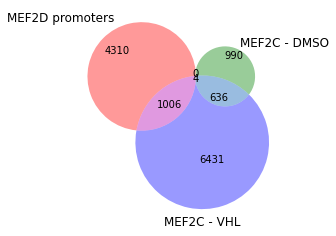

In [121]:
venn3(subsets = (6124-(1006+808+0), 990-0, 0, 7437-1006, 1006, 636, 4), set_labels = ('MEF2D promoters', 'MEF2C - DMSO', 'MEF2C - VHL'))

In [74]:
MEF2D['promoters'] = chip.putInBed(MEF2D, promoters)

8579 were merged into conscensus


In [84]:
# analysis on enhancers
MEF2D['enhancers'] = chip.putInBed(MEF2D, '../data/Cobinding_ChIP/MV411_H3K27ac/mp136-MV411-H3K27ac-r1.broadPeak.bed', window=100)
MEF2D.loc[MEF2D[MEF2D["promoters"]!=0].index, "enhancers"] = 0

0.04098501808162562

8411 were merged into conscensus


In [118]:
MEF2Denh = MEF2D[MEF2D.enhancers!=0]

In [119]:
len(MEF2Denh), len(MEF2Denh[MEF2Denh["MEF2C_VHL"]!=0]), len(MEF2Denh[MEF2Denh["MEF2C_DMSO"]!=0]), len(MEF2Denh[MEF2Denh["MEF2C_common"]!=0])

(2326, 836, 5, 3)

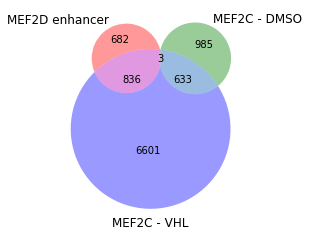

In [122]:
venn3(subsets = (2326-(836+808+0), 990-5, 5, 7437-836, 836, 636-3, 3), set_labels = ('MEF2D enhancer', 'MEF2C - DMSO', 'MEF2C - VHL'))

In [ ]:
name = ""
chip.getPeaksAt(cond2peak[], [], bigwignames=[''], peaknames=[''], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/diffPeaks/'+name+'_mat.pdf', withDeeptools=True, torecompute=False)

In [20]:
bw

['../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R2.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R1.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MED1_R2.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R2.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R1.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MYC_R2.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-POLII_total_R1.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-POLII_total_R2.bw',
 '../../data/MEF2D_degraded_v3/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL_2h-FLAG_MEF2D_R1.bw',
 '../../data/MEF2D_degraded_v3/

In [ ]:
['H3K27ac']
merged.loc[merged[(merged["promoter"]>0) | merged["super_enhancer"]>0].index, 'enhancer'] = 0

In [53]:
cond2peak[0]

'../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_R1_treat_pileup_c3.0_cond2.bed'

In [54]:
name="MEF2C binding under MEF2D peaks in MEF2D degron"
i = 0
u,v = 3,9
chip.getPeaksAt([cond1peak[i],commonpeak[i],cond2peak[i]], [bw[u], bw[v]], bigwignames=['MEF2C signal in DMSO', 'MEF2C signal in VHL'], peaknames=['DMSO', 'common', 'VHL'], window=3000, folder="", title=name, numthreads=8, refpoint="center", name='../../data/'+project+'/diffPeaks/'+name.replace(' ', '_')+'_mat.pdf', withDeeptools=True, torecompute=True)

CompletedProcess(args="computeMatrix reference-point -S ../../data/MEF2D_degraded_v1/recalib_bigwig/MV411_MEF2D_NT_SC_63_DMSO-MEF2C_R1.bw ../../data/MEF2D_degraded_v1/recalib_bigwig/MV411_MEF2D_NT_SC_63_VHL-MEF2C_R1.bw  --referencePoint center --regionsFileName ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_R1_treat_pileup_c3.0_cond1.bed ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_R1_treat_pileup_c3.0_common.bed ../../data/MEF2D_degraded_v1/diffPeaks/MV411_MEF2D_NT_SC_63_DMSO-FLAG_MEF2D_R1_treat_pileup_vs_MV411_MEF2D_NT_SC_63_VHL-FLAG_MEF2D_R1_treat_pileup_c3.0_cond2.bed  --missingDataAsZero --outFileName ../../data/MEF2D_degraded_v1/diffPeaks/MEF2C_binding_under_MEF2D_peaks_in_MEF2D_degron_mat.gz --upstream 3000 --downstream 3000 --numberOfProcessors 8 && plotHeatmap --matrixFile ../../data/MEF2D_degraded_v1/diffPeak

#### Looking at TSS

In [ ]:
indextarget = 
targetFile = '../results/slamseqMax/IRF8targets.txt'
if targetFile && indextarget:
IRF8targets = h.fileToList(targetFile)

In [ ]:
def loadPeaks(file):
    a = pd.read_csv(cond2peak[indextarget], sep='\t',header=None, skiprows=1, names=['chrom','start','end','name','score'])
    a['chrom']= [i[3:] for i in a['chrom']]
    a[['start','end']] = a[['start','end']].astype(int)
    return a

peaksVHL = loadPeaks(cond2peak[indextarget])
peaksDMSO = loadPeaks(cond1peak[indextarget])
peakcommon = loadPeaks(commonpeak[indextarget])

In [ ]:
ensembltss['Chromosome/scaffold name'] = ensembltss['Chromosome/scaffold name'].astype(str)
ensembltss = ensembltss[ensembltss['Chromosome/scaffold name'].isin(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9','X','Y'])]
ensembltss = ensembltss.drop_duplicates('Gene start (bp)')
ensembltss = ensembltss.reset_index(drop=True)
ensembltss = ensembltss.astype(str)
ensembltss['loci'] = ensembltss['Transcription start site (TSS)'].astype(int)
ensembltss['chrom'] = ensembltss['Chromosome/scaffold name']
ensembltss = ensembltss.sort_values(by=['chrom','loci']).reset_index(drop=True)

In [ ]:
chip.substractPeaksTo(peaksDMSO, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_DMSO_TSSonly.bed',sep='\t',index=None,header=False)
chip.substractPeaksTo(peakcommon, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_common_TSSonly.bed',sep='\t',index=None,header=False)
chip.substractPeaksTo(peaksVHL, ensembltss).to_csv('../../data/'+project+'/diffPeaks/polII_VHL_TSSonly.bed',sep='\t',index=None,header=False)

In [ ]:
chip.getPeaksAt(['../../data/'+project+'/diffPeaks/polII_DMSO_TSSonly.bed', '../../data/'+project+'/diffPeaks/polII_common_TSSonly.bed', '../../data/'+project+'/diffPeaks/polII_VHL_TSSonly.bed'],
                bigwigs = ['../../data/chipseq_IRF8_degraded/recalib_bigwig/MV411_IRF8_NT_DMSO-POLII_total_R1.bw', '../../data/chipseq_IRF8_degraded/recalib_bigwig/MV411_IRF8_NT_VHL-POLII_total_R1.bw'], 
                bigwignames= ['IRF8_DMSO', 'IRF8_VHL'], 
                peaknames=['DMSO','common','VHL'], window=3000, folder="", title='polII_with_IRF8_degron', numthreads=4, 
                refpoint="center", 
                name='../../data/'+project+'/diffPeaks/polII_with_IRF8_degron_mat.pdf', 
                withDeeptools=True, torecompute=True, legendLoc="lower-left")

In [ ]:
IRF8tss = ensembltss[ensembltss['Gene name'].isin(IRF8targets)].reset_index(drop=True)

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_DMSO_TSSonly.bed 

In [ ]:
int(a[0].split(' ')[0])/len(peaksDMSO), len(peaksDMSO)

In [ ]:
len(chip.substractPeaksTo(peaksDMSO, IRF8tss))/int(a[0].split(' ')[0])

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_common_TSSonly.bed 

In [ ]:
int(a[0].split(' ')[0])/ len(peakcommon),  len(peakcommon)

In [ ]:
len(chip.substractPeaksTo(peakcommon, IRF8tss))/int(a[0].split(' ')[0])

In [ ]:
a = ! wc -l ../../data/$project/diffPeaks/polII_VHL_TSSonly.bed 
print('nb of VHL peaks '+str(len(peaksVHL)))
print("" + str(int(a[0].split(' ')[0])/len(peaksVHL)) + "" +  str(len(peaksVHL)))
print("" + str(len(chip.substractPeaksTo(peaksVHL, IRF8tss))/int(a[0].split(' ')[0])))

### on unscalled data

In [ ]:
! mkdir ../../data/$project/diffPeaks_unscaled

In [ ]:
#on unscalled data 
for i in range(int(len(bams)/2)):
    if i < 0:
        continue
    name1 = bams[1+i]
    name2 = bams[1+len(names)+i]
    print(name1,name2)
    chip.fullDiffPeak(name1,name2, control1='../../data/'+project+'/bwa/mergedLibrary/INPUT_R1.mLb.clN.sorted.bam', directory = "../../data/"+project+"/diffData_unscaled/", res_directory = "../../data/"+project+"/diffPeaks_unscaled/",pairedend=False)

In [ ]:
bw = ! ls ../../data/$project/bwa/mergedLibrary/bigwig/*.bigWig
bw

In [ ]:
cond1peak = ! ls ../../data/$project/diffPeaks_unscaled/*cond1.bed
cond2peak = ! ls ../../data/$project/diffPeaks_unscaled/*cond2.bed
commonpeak = ! ls ../../data/$project/diffPeaks_unscaled/*common.bed
commonpeak

In [ ]:
for i in range(int((len(bw)-1)/2)):
    name1 = bw[1+i]
    name2 = bw[1+len(names)+i]
    peak = [cond1peak[i], commonpeak[i], cond2peak[i]]
    #for val in peak:
     #   chip.dropWeirdChromosomes(val)
    name = names[i]
    print(name1,name2)
    chip.getPeaksAt(peak, [name1, name2], bigwignames=['DMSO', 'VHL'], peaknames=['DMSO_peaks', 'common', 'VHL_peaks'], window=3000, folder="", title=name, numthreads=8, torecompute=True, refpoint='center', name='../../data/'+project+'/diffPeaks_unscaled/'+name+'_mat.pdf', withDeeptools=True)

In [ ]:
h.createFoldersFor('../results/'+project+'/plots/unscaled/diffPeaks/')
! cp ../../data/$project/diffPeaks_unscaled/*.pdf ../results/$project/plots/unscaled/diffPeaks/

! gsutil -m cp gs://amlproject/Chip/$project/bwa/mergedLibrary/deepTools/**.pdf ../results/$project/plots/

In [ ]:
! gsutil -m cp -r ../../data/$project/diffPeaks gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffData gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffPeaks_unscaled gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/diffData_unscaled gs://amlproject/Chip/$project/
! gsutil -m cp -r ../../data/$project/peakplot gs://amlproject/Chip/$project/

In [33]:
! gsutil -m cp -r gs://amlproject/Chip/$project/diffPeaks ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffData ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffPeaks_unscaled ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/diffData_unscaled ../../data/$project/
! gsutil -m cp -r gs://amlproject/Chip/$project/peakplot ../../data/$project/

Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_v2_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/AAVS1_v2_mat.pdf...         
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_mat.pdf...             
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_v2_mat.gz...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/IRF8_v2_mat.pdf...          
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_v2_mat.gz...          
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MEF2D_v2_mat.pdf...
Copying gs://amlproject/Chip/knockouts_v1/diffPeaks/MV411_RNP_AAVS1-H3K27AC_R1_treat_pileup_vs_MV411_RNP_IRF8-H3K27AC_R1_treat_pileup_c3.0_common.bed...
Copying gs://amlproject/Chip/knockout

- [73/73 files][  1.8 GiB/  1.8 GiB] 100% Done                                  
Operation completed over 73 objects/1.8 GiB.                                     
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_control_lambda.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_peaks.narrowPeak...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_peaks.xls...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_summits.bed...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R1_treat_pileup.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_control_lambda.bdg...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_peaks.narrowPeak...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H3K27AC_R2_peaks.xls...
Copying gs://amlproject/Chip/knockouts_v1/diffData/MV411_RNP_AAVS1-H

[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
[Errno 28] No space left on device
CommandException: Some components of ../../data/knockou